# Introduction
In the Consumer Packaged Goods (CPG) industry, product images are becoming popular in web based applications and planogramming tools. Use of  images and alternate views of products enhance user experience and are sometimes more intuitive than textual product descriptions. However it becomes cumbersome and expensive to manage, track and catalog millions of product images manually. The objective of this project is to test and compare various machine learning techniques to classify and label product images into product categories.  

In [29]:
#################################################################
# Import packages 
#################################################################
%matplotlib inline
import sys
from time import time
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
from scipy import interp
from collections import Counter
from matplotlib import pyplot as plt
from skimage import data, io, filters, feature
from skimage.color.colorconv import rgb2grey
from skimage.transform import resize
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn import svm, neighbors, preprocessing
from sklearn.preprocessing import normalize,LabelBinarizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier,  ExtraTreesClassifier
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report, roc_curve,roc_auc_score, auc
from sklearn.grid_search import GridSearchCV
from sknn.mlp import Convolution, Classifier, Layer
from sklearn.decomposition import PCA
from sknn.backend import lasagne

# Dataset

100 front-facing product images in the PNG format and corresponding text labels stored in a CSV file are read into memory. Fig 1 below shows the distribution of the 8 retail categories in the image data set.

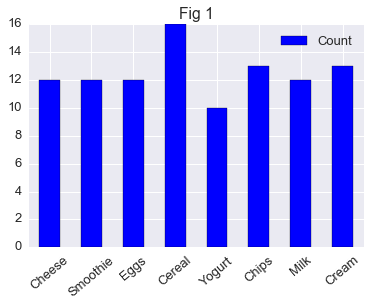

In [30]:
#read ordered labels from CSV file 
labels = pd.read_csv("img/labels.csv")
y = labels.values.ravel()
df = pd.DataFrame.from_dict(Counter(y), orient='index')
df.columns = ['Count']
df.plot(kind='bar', figsize = (6,4), title = "Fig 1")
locs, labels_text = plt.xticks()
plt.setp(labels_text, rotation=40)
plt.show()

# Image Processing

Since each of the product categories have distinct object shapes, edge detection algorithms are expected to perform well in extracting features for this classification problem. [Sobel](https://en.wikipedia.org/wiki/Sobel_operator) and [Canny](https://en.wikipedia.org/wiki/Canny_edge_detector) edge detection techniques are applied on a low resolution sample of the raw image files. Some of the processed images are visually compared below to verify the results of edge detection. The Sobel algorithm will be selected to process images because, unlike Canny, it places more emphasis on the edges and captures the essential features for shape recognition. 

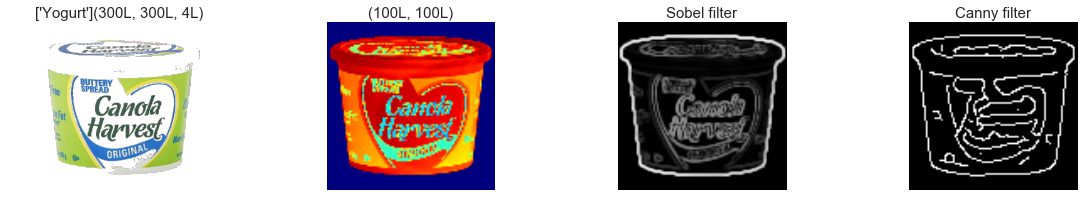

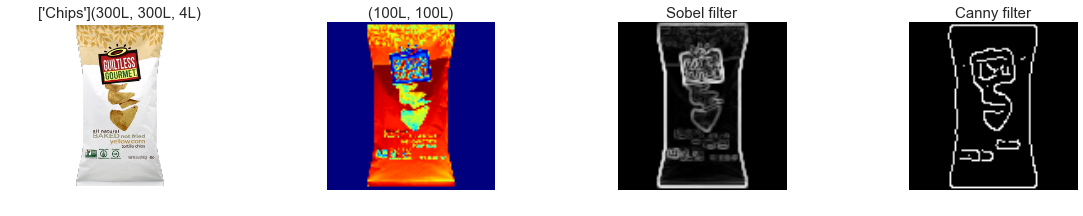

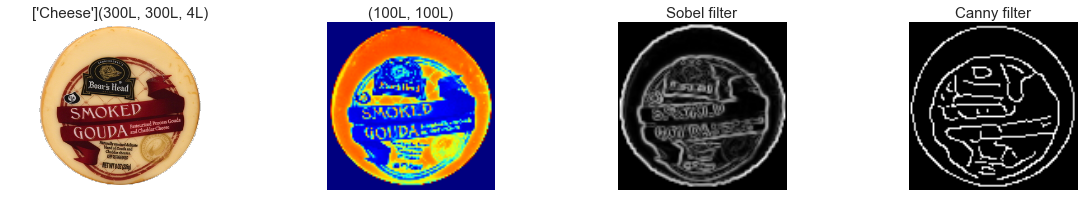

In [31]:
#################################################################
# Read and Process images 
#################################################################
imgs_shaped = []
#global constants
TITLE_SIZE = 15
RANDOM_STATE = 17
IMG_DIM = 100
SAMPLE_SIZE = 100

#read images in order
for i in range(1,SAMPLE_SIZE+1):
    img = io.imread('img/' + `i` + '.png')
    
    #resize image to lower resolution
    img_grey = rgb2grey(img)
    img_resized = resize(img_grey, (IMG_DIM, IMG_DIM))
    
    #apply filters
    img_sobel = filters.sobel(img_resized)
    img_canny = feature.canny(img_resized, sigma=2) 

    #sample some image feature extraction
    if i < 4:
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(20, 3))
        
        ax1.imshow(img, cmap=plt.cm.jet)
        ax1.axis('off')
        ax1.set_title(str(labels.values[i-1]) + str(img.shape) , fontsize = TITLE_SIZE)

        ax2.imshow(img_resized, cmap=plt.cm.jet)
        ax2.axis('off')
        ax2.set_title(str(img_resized.shape), fontsize = TITLE_SIZE)

        ax3.imshow(img_sobel, cmap=plt.cm.gray)
        ax3.axis('off')
        ax3.set_title('Sobel filter' , fontsize = TITLE_SIZE)

        ax4.imshow(img_canny, cmap=plt.cm.gray)
        ax4.axis('off')
        ax4.set_title('Canny filter' , fontsize = TITLE_SIZE)

    #select the Sobel filter
    imgs_shaped.append(img_sobel.ravel())
#end-for

#Convert all images to NP array         
imgs_shaped = np.asarray(imgs_shaped) 
#set X values
X = imgs_shaped

## What does the classifer see ?{-}

**Pixel importances** - Since we are dealing with raw images, it is useful to see how a classifier extracts the important features. In Fig 3, the 2D image data was fit to an ExtraTreesClassifier to determine pixels importances for classification. The brighter pixels are given more weightage by the classifier. The number of estimators are increased to get a better picture.

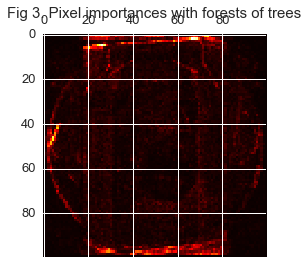

In [32]:
#################################################################
# Build a forest and compute the pixel importances 
#################################################################
forest = ExtraTreesClassifier(n_estimators=4000, n_jobs=1, random_state=RANDOM_STATE)
forest.fit(X, y)
importances = forest.feature_importances_
importances = importances.reshape(IMG_DIM, IMG_DIM)

# Plot pixel importances
_, ax = plt.subplots(figsize=(4, 4))
ax.matshow(importances, cmap=plt.cm.hot)
plt.title("Fig 3. Pixel importances with forests of trees", fontsize = TITLE_SIZE)
plt.show()

## Determine Estimator Size

We will be using tree ensembles later. It would be computationally efficient to determine an optimum size of the *n_estimators* parameter. Below we see that the classification score doesn't improve beyond n_estimators = 60.    

In [33]:
#################################################################
# Plot Classification Score Vs Num. of trees  
#################################################################
scores = []
for val in range(1,80):
    rf = RandomForestClassifier(n_estimators = val)
    validated = cross_val_score(rf, X, y, cv=4)
    scores.append(validated)

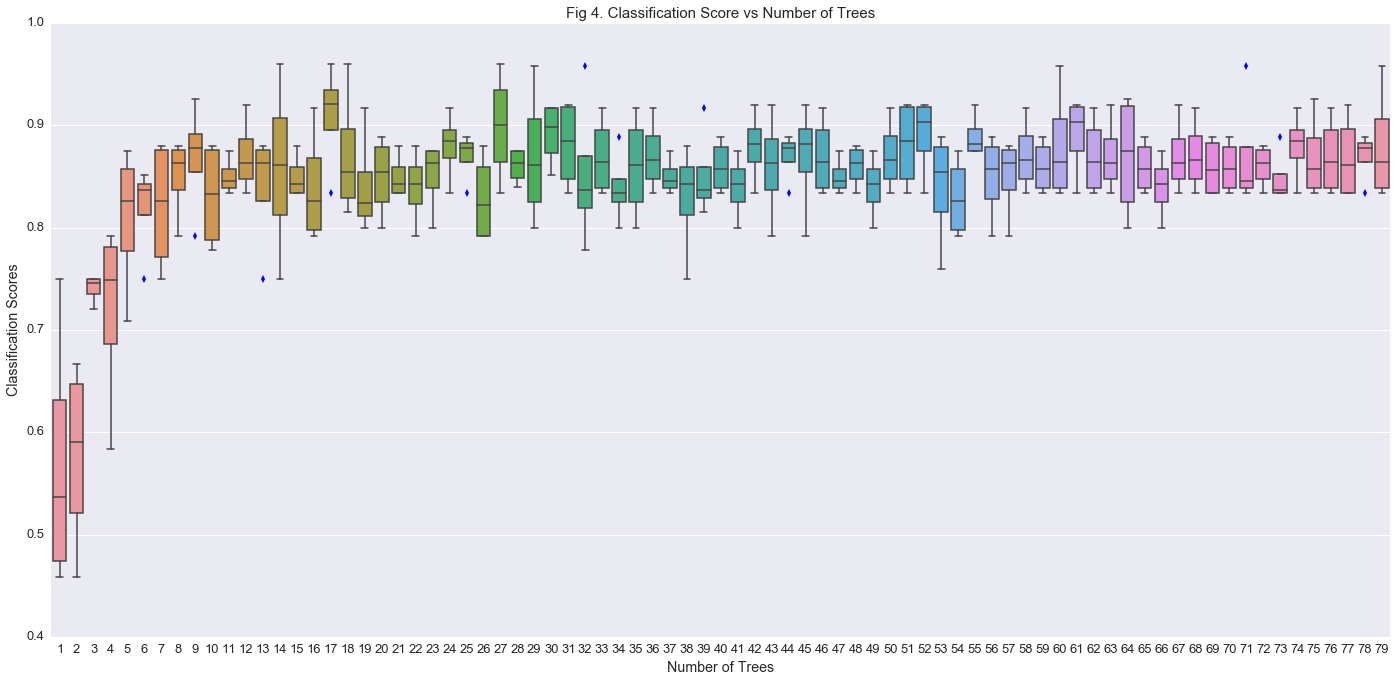

In [34]:
plt.subplots(figsize=(24, 11))
sns.boxplot(range(1,80), scores)
plt.xlabel('Number of Trees')
plt.ylabel('Classification Scores')
plt.title('Fig 4. Classification Score vs Number of Trees', fontsize = TITLE_SIZE)
plt.show()

# Model Generation

An ensemble of classification models would be fit to a training images dataset and tested against a test dataset. Where applicable, exhaustive grid search using GridSearchCV is used to scan a range of parameters to obtain best results using N-fold cross-validation. 

### `Split Data`

The data is split into training 60% and 40% test sets. Fig 5 shows distribution of the train and test data.

In [35]:
#split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=RANDOM_STATE)

#create binarized labels
lb = LabelBinarizer()
y_train_bin = lb.fit_transform(y_train)
y_test_bin = lb.fit_transform(y_test)

#Ensure that the random test sample sees all the labels
print "Total dataset X:", X.shape, "y:", len(y)
print "Training set:", X_train.shape, "Testing set:" , X_test.shape
assert(y_test_bin.shape[1] == y_train_bin.shape[1])

Total dataset X: (100L, 10000L) y: 100
Training set: (60L, 10000L) Testing set: (40L, 10000L)


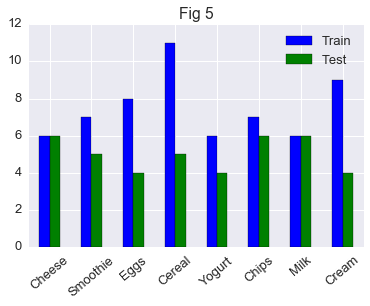

In [36]:
#Plot train and test label frequencies
df1 = pd.DataFrame.from_dict(Counter(y_train), orient='index')
df2 = pd.DataFrame.from_dict(Counter(y_test), orient='index')
df = pd.concat([df1, df2], axis=1)
df.columns=['Train', 'Test']
df.plot(kind='bar', figsize = (6,4), title = "Fig 5")
locs, labels_text = plt.xticks()
plt.setp(labels_text, rotation=40)
plt.show()

### `Define Classifiers`

Although certain models such as Neural Networks and Trees are known to outperform other methods for image classification, we will compare various methods in the list below during the modeling process. The best estimators from Grid Search can be seen in the [Appendix](#Appendix). In addition to train-test split, we will apply a 3-fold cross-validation for the grid search. Also, given the analysis above, the estimator size will be set to 100. Since computation is being run on a Windows platform it will run single-threaded given known limitations of iPython.

In [37]:
#################################################################
# Declare model parameters and search ranges
#################################################################
N_ESTIMATORS =  100
CV = 3
N_JOBS = 1
BATCH_SIZE = 30
NUM_EPOCHS = 50
NUM_HIDDEN_UNITS = 400
LEARNING_RATE = 0.01
MOMENTUM = 0.7 

layers1=[Layer("Sigmoid",  name = "Sigmoid", units=NUM_HIDDEN_UNITS), Layer("Softmax", name = "SM0")]
layers2=[Convolution("Rectifier", name = "Rect1", channels=8, kernel_shape=(3,3)),Layer("Softmax", name = "SM1")]
layers3=[Convolution("Rectifier", name = "Rect2", channels=8, kernel_shape=(2,2)),Layer("Softmax", name = "SM2")]
layers4=[Convolution("Tanh", name = "Tanh", channels=8, kernel_shape=(3,3)),Layer("Softmax", name = "SM3")]

C_range = [1e-2, 1, 1e2, 1e3, 1e4, 1e5, 1e6]
gamma_range = [1e-4, 1e-3, 1e-2, 1, 1e2, 1e3, 1e4]
learning_rate_range = [0.005, 0.001, 0.0005] 
degree_range = [1,2,3,4]
neighbors_range = {"n_neighbors" : [2,3,4]}
penalty_range = {"penalty" : ['none', 'l2', 'l1', 'elasticnet']}

ridge_param_grid = [
    {"alpha" : C_range}
]
svm_param_grid = [
    {"C" : C_range, "kernel": ['linear']},
    {"C" : C_range, "gamma" : gamma_range, "kernel": ['rbf']},
    {"C" : C_range, "gamma" : gamma_range, "degree" : degree_range, "kernel": ['poly']}
]

nn_param_grid = [
    {"layers":[layers1,layers2,layers3,layers4], 
     "learning_momentum" : [0.5,0.6,0.7],
     "learning_rate": learning_rate_range}
]

In [38]:
#################################################################
# Declare classifiers using parameters above
#################################################################
classifiers ={
    "SVM" : GridSearchCV(svm.SVC(probability=True), param_grid = svm_param_grid, 
                         n_jobs= N_JOBS, cv = CV, refit=True),
    
    "KNN" : GridSearchCV(neighbors.KNeighborsClassifier(), param_grid = neighbors_range, 
                         n_jobs= N_JOBS, cv = CV, refit=True),
    
    "LogisticRegression": GridSearchCV(LogisticRegression(multi_class='multinomial', solver='lbfgs'),
                                       param_grid = [{"C" : C_range}], n_jobs= N_JOBS, cv = CV, refit=True),
    
    "RandomForest":  RandomForestClassifier(n_estimators = N_ESTIMATORS),
    
    "GradientBoosting": GridSearchCV(GradientBoostingClassifier(n_estimators = N_ESTIMATORS), 
                                     param_grid = [{"learning_rate" : learning_rate_range}]
                                     , n_jobs= N_JOBS, cv = CV, refit=True),
    
    "Bagging": BaggingClassifier(n_estimators = N_ESTIMATORS),
    
    "ExtraTrees": ExtraTreesClassifier(n_estimators = N_ESTIMATORS),
    
    "Ridge" : GridSearchCV(RidgeClassifier(), param_grid = ridge_param_grid, n_jobs= N_JOBS, cv = CV, refit=True),
    
    "SGD" : GridSearchCV(SGDClassifier(loss="log"), param_grid = penalty_range, n_jobs= N_JOBS, cv = CV, refit=True),
    
    "NeuralNetwork" : GridSearchCV(Classifier(layers = layers1,n_iter=NUM_EPOCHS), 
                                    param_grid = nn_param_grid, n_jobs= N_JOBS, cv = CV, refit=True),
}
# print '\n'.join(map(str, classifiers.keys()))

### `Generate Models`

The results of model execution are printed below.

In [39]:
#define metrics
metrics = pd.DataFrame(columns=['Classifier', 'Test Score', 'Train Score', 'Train Time'])

#define output reports
confusion_matrices = {}
classification_reports = {}

#iterate through all classifiers
for name,clf in classifiers.iteritems():
    print "Fitting" , name
    
    #train
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    train_preds = clf.predict(X_train)

    #test
    t1 = time()
    test_preds = clf.predict(X_test)
    test_time = time() - t1

    #accuracy score
    test_score = accuracy_score(y_test,test_preds)
    train_score = accuracy_score(y_train,train_preds)

    #confusion matrix
    confusion_matrices[name] =  pd.crosstab(index=y_test, columns=test_preds.ravel(), rownames=['True'], colnames=['Predicted'])
    #classification report
    classification_reports[name] =  classification_report(y_test,test_preds)

    #generate metrics
    metrics = metrics.append({'Classifier' : name, 'Test Score' : test_score, 'Train Score' : train_score, 'Train Time' : train_time},
                         ignore_index=True) 

Fitting KNN
Fitting Bagging
Fitting SVM
Fitting Ridge
Fitting ExtraTrees
Fitting NeuralNetwork
Fitting RandomForest
Fitting LogisticRegression
Fitting SGD
Fitting GradientBoosting


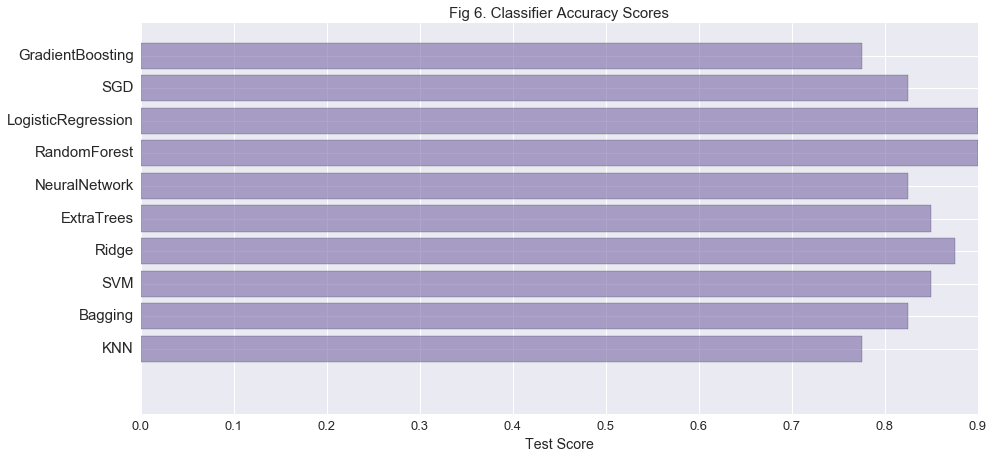

In [40]:
# Plot Accuracy Scores
y_pos = np.arange(len(metrics)) 
plt.figure(figsize=(15, 7))
plt.barh(y_pos, metrics['Test Score'] ,align='center', alpha=0.6, color='#7A68A6')
plt.yticks(y_pos, metrics['Classifier'],fontsize = TITLE_SIZE)
plt.xlabel('Test Score')
plt.title('Fig 6. Classifier Accuracy Scores', fontsize = TITLE_SIZE)
plt.show()

In [41]:
metrics.sort_values(by=['Test Score'], ascending=[0])

,Classifier,Test Score,Train Score,Train Time
6,RandomForest,0.900,1.00,0.280
7,LogisticRegression,0.900,1.00,11.483
3,Ridge,0.875,1.00,0.254
2,SVM,0.850,1.00,147.665
4,ExtraTrees,0.850,1.00,0.233
1,Bagging,0.825,1.00,9.451
5,NeuralNetwork,0.825,1.00,586.388
8,SGD,0.825,1.00,1.624
0,KNN,0.775,0.85,0.366
9,GradientBoosting,0.775,1.00,181.773



## `Confusion Matrices`

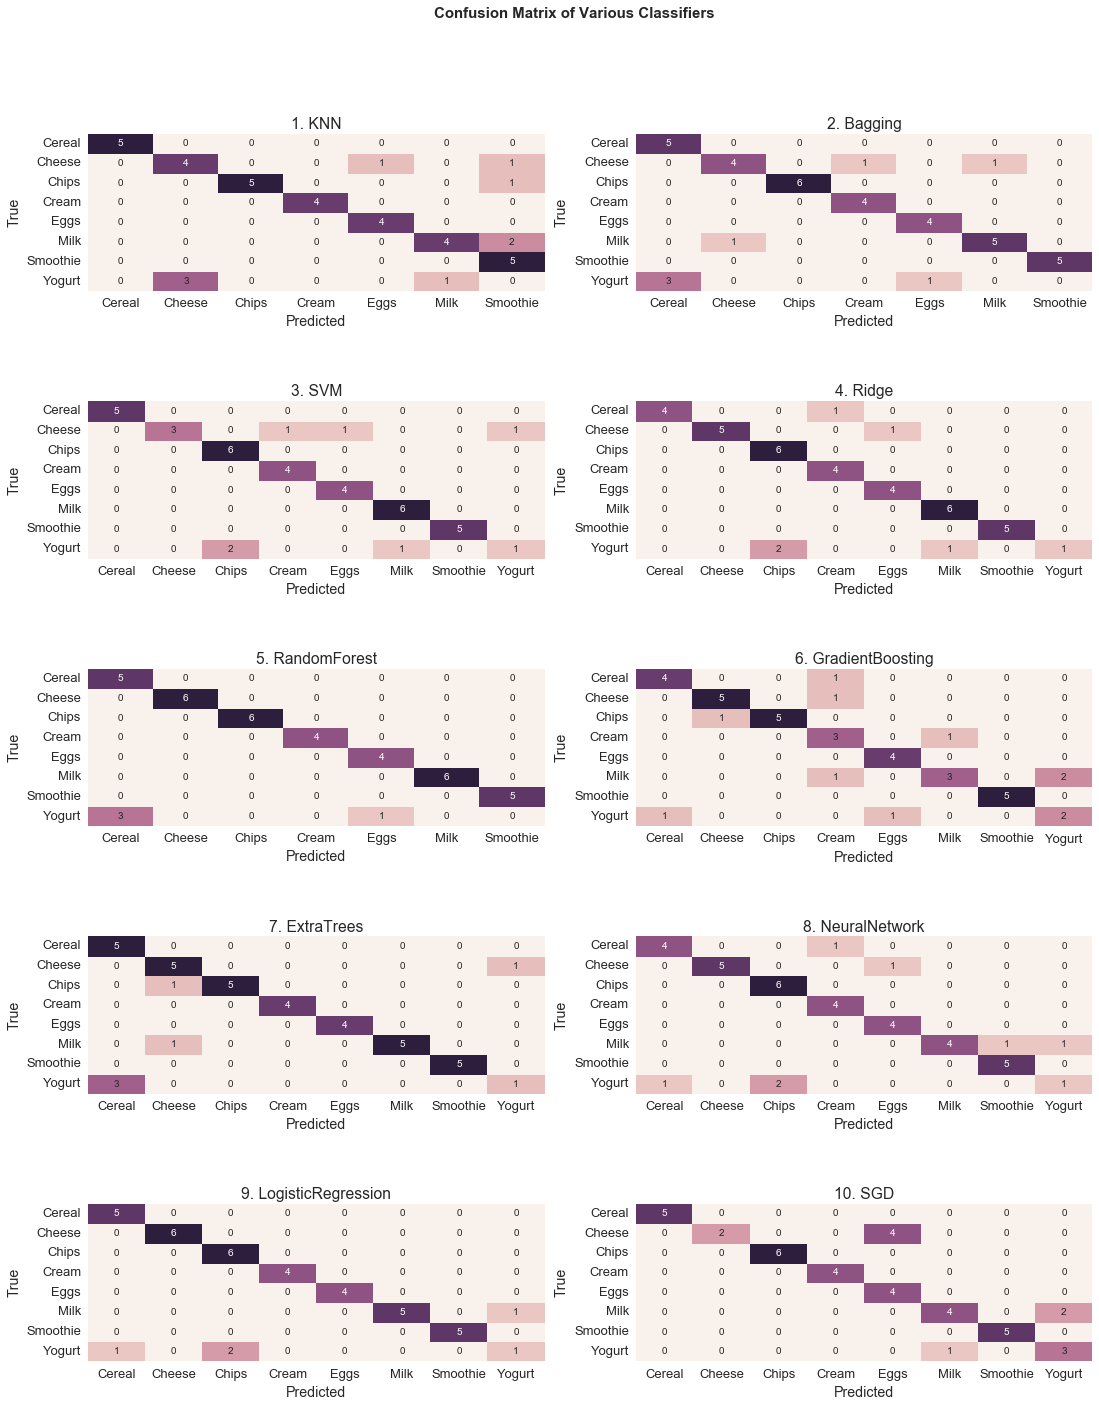

In [42]:
# Plot Confusion Matrices
fix, ax = plt.subplots(figsize=(18, 22))
plt.suptitle('Confusion Matrix of Various Classifiers', fontsize=TITLE_SIZE, fontweight='bold')
sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 1.5})
size = len(classifiers.keys())/2
i = 1
for name, matrix in confusion_matrices.items():
    plt.subplot(size,2, i)
    plt.title(str(i) + ". " + name)
    sns.heatmap(matrix, annot=True, square=False, fmt='', cbar=False)
    plt.subplots_adjust(hspace=.7)  
    i += 1

## `Receiver Operating Characteristics`

Plot multi-class ROCs using macro-AUC averages for all classes.

In [ ]:
#################################################################
# Compute the Marco Avg. AUC scores for all classes
#################################################################
def compute_macro_auc (clf):
    #Predict each class against the other
    classifier = OneVsRestClassifier(clf)
    y_score = classifier.fit(X_train, y_train).predict_proba(X_test)
    n_classes = y_test_bin.shape[1]
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # Then interpolate all ROC curves
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes
    roc_auc = auc(all_fpr,mean_tpr)

    #macro AUC
    return all_fpr, mean_tpr, roc_auc

In [ ]:
#compute macro AUC
macro_auc = {}
for name,clf in classifiers.iteritems():
    try:
        macro_auc[name] = compute_macro_auc(clf)
    except:
        print "Error processing: ", name
        continue

In [ ]:
#################################################################
# Plot ROC Curves
#################################################################
fpr_rand = tpr_rand = np.linspace(0, 1, 10)
plt.figure(figsize=(15, 8))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.plot(fpr_rand, tpr_rand, lw=1, linestyle='--', label='Random Baseline')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC - Macro AUC', fontsize = TITLE_SIZE)
plt.legend(loc='lower right', prop={'size':15})
#iterate classifiers and plot ROC
for name in macro_auc:
    #Area Under Curve
    x = macro_auc[name] 
    fpr = x[0]
    tpr = x[1]
    roc_auc = x[2]
    if roc_auc != "na":
        plt.plot(fpr, tpr, lw=2, label= str(name) + ' area = {0:0.2f}'''.format(roc_auc))
        plt.legend(loc='lower right', prop={'size':15})
plt.show()




## Holdout Testing

To test model performance we will run two of the best cross-validated classifier against images it has never seen before. The Neural Network correctly predicts all images and also recognizes different shapes of milk cans, yogurt, cheese and eggs. The Logistic Regression correctly labels all but one where it labels a "Yogurt" as "Chips".  

In [ ]:
imgs_raw = []
imgs_test = []

#read unlabeled images
TEST_IMAGES = 30
for i in range(1,TEST_IMAGES+1):
    img = io.imread('test/' + `i` + '.png')
    imgs_raw.append(img)
    #resize image to lower resolution
    img_grey = rgb2grey(img)
    img_resized = resize(img_grey, (IMG_DIM, IMG_DIM))
    #apply filters
    img_sobel = filters.sobel(img_resized)
    img_shaped = img_sobel.ravel()
    imgs_test.append(img_shaped)

#collect all test images    
imgs_test = np.asarray(imgs_test)

### `Neural Network Classifier`

In [ ]:
#store the output predictions    
pred_labels = classifiers["NeuralNetwork"].predict(imgs_test)

#label images for display
COL_SIZE = 6
for i in range(0,len(imgs_test),COL_SIZE):
    fig, ax = plt.subplots(nrows=1, ncols=COL_SIZE, figsize=(20, 15))
    for j in range(0,len(ax)):
        if i+j < TEST_IMAGES:
            ax[j].imshow(imgs_raw[i+j], cmap=plt.cm.jet)
            ax[j].axis('off')
            ax[j].set_title(pred_labels[i+j], fontsize = TITLE_SIZE, fontweight='bold')

### `Logistic Regression Classifier`

In [ ]:
#store the output predictions    
pred_labels = classifiers["LogisticRegression"].predict(imgs_test)

#label images for display
COL_SIZE = 6
for i in range(0,len(imgs_test),COL_SIZE):
    fig, ax = plt.subplots(nrows=1, ncols=COL_SIZE, figsize=(20, 15))
    for j in range(0,len(ax)):
        if i+j < TEST_IMAGES:
            ax[j].imshow(imgs_raw[i+j], cmap=plt.cm.jet)
            ax[j].axis('off')
            ax[j].set_title(pred_labels[i+j], fontsize = TITLE_SIZE, fontweight='bold')

# Conclusion

The tests were run with and without image filters. The use of a Sobel filter on the images helped improved the test accuracy scores. Other image processing techniques such use of pixel distribution histograms instead of raw pixels could also be applied. 

Although most classifiers are able to distinguish beween well differentiated shapes such as "Eggs" and "Smoothie", classifing similar-shaped images of "Chips", "Yogurt" and "Cereal" is challenging. This can be seen from the confusion matrices in the [Appendix](#Appendix). Some improvement was seen by selecting better training samples and applying cross-validation, but further work needs to be done. 

Neural Network and Logistic Regression consistently prediced the test set with over 90% accuracy score. In the hold out test the Neural Network predicted all samples with 100% accuracy.  Although Neural Networks take a longer time to train, they may be better suited for generalizing more complex and noisy images and a larger number of classes. As can be seen in the best estimator selection in the [Appendix](#Appendix), the Convolution Recitifier performs best among the neural network configurations. It is also interesting to note that tree based classfiers - Extra Trees and Random Forests provide satisfactory results with minimal training time.

To solve this problem at industrial scale however, a broader set of product categories with noise needs to be tested on larger machines with multiple cores or GPUs. Also additional techniques besides shape detection would need to be applied to correctly classify product categories that have similar shapes.   

## Persist Model


In [ ]:
pickle.dump( classifiers["NeuralNetwork"], open( "NNModel.p", "wb" ) )

# Appendix

## `Classification Report`

In [ ]:
#################################################################
# Print Classification Reports
#################################################################
for name, matrix in classification_reports.items():
    print "----------------------------------------------------------"
    print name
    print "----------------------------------------------------------"
    print matrix

## `Selected Classifiers`

In [ ]:
#################################################################
# Print Best Classifiers selected in Grid Search
#################################################################
for name,clf in classifiers.iteritems():
    try:
        print "----------------------------------------------------------"
        print name
        print "----------------------------------------------------------"
        print clf.best_estimator_ 
    except:
        print clf
        continue